# Miami Home Sale Price Prediction Model
#### for single-family homes sold in 2021

### TO DO

In [29]:
# [X] ? TUNE the XGB model.
# [ ]  CREATE Model Results dataframe for comparing predictions of all models. 

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

# O. Wrangle Data
   - LINK TO DATA :  https://www.kaggle.com/deepcontractor/miami-housing-dataset
   
   - Attempted to remove outliers, but model performed worse with outliers removed. Further testing required to determine if this is due to overfitting or it truly is more accurate. Some options are implementing variations on cross validation, or trying an alternative tree-based model (as the tree-based XGBoost algorithm has given the best results).

In [31]:
def get_quantiles(col):
    return col.quantile(.25), col.quantile(.75) - col.quantile(.25), col.quantile(.75)
# pd.Series(get_quantiles(df['sale_prc'])).plot()

In [32]:
def wrangle(data_path):
    df = pd.read_csv('miami-housing.csv')

    df.columns = df.columns.str.lower()

    df.drop('parcelno', axis=1, inplace=True)

#     outlier_cols = ['spec_feat_val', 'subcntr_di']
#     q1, iqr, q3 = get_quantiles(df['spec_feat_val'])
#     lower_fence = q1 - 1.5 * iqr
#     upper_fence = q3 + 1.5 * iqr
#     mask = (df['spec_feat_val'] >= lower_fence) & (df['spec_feat_val'] <= upper_fence)

#     return df[mask]

    return df

In [33]:
df = wrangle('/data/miami-housing.csv')

### Wrangling To-Do: 

In [34]:
# [ ]  CONVERT 'avno60plus', 'structure_quality' dtype to 'object'

# **********************************************************************************

# [ ]  SPLIT data into categorical df and numerical df (first try w/o this)

# [ ]  DIVIDE 'hwy_dist' into tiers, MAKE CATEGORICAL?
#        - more tiers: water_score, shop_score, noise_score
# [ ]  CREATE "amenity_score" (1-5? 1-3?) from 'spec_feat_val'

### Outliers:

In [35]:
features_to_tier = ['spec_feat_val', 'water_dist', 'ocean_dist', 'cntr_dist', 'subcntr_di']

# df[features_to_tier].describe()

<AxesSubplot:>

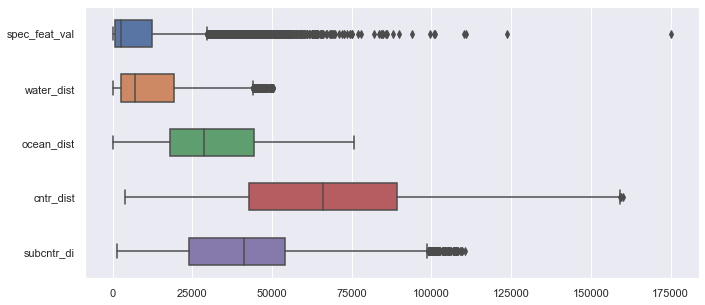

In [36]:
#  TRY using StandardScaler before dropping outliers in any column
#  ---- OR.... just use a ***Tree-based Model***
#  *****************************************************************************
#  ---- seaborn resizing here: sns.set(rc = {'figure.figsize':(15,8)}) ----
#  *****************************************************************************
import seaborn as sns

sns.set(rc = {'figure.figsize':(11,5)})
sns.boxplot(data = df[features_to_tier], orient='h', width=.5)


# I. Split Data

In [37]:
from sklearn.model_selection import train_test_split

#  CREATE feature matrix and target vector
target = 'sale_prc'
X = df.drop(target, axis=1)
y = df[target]

#  Training and validation split:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size= 0.4, random_state= 42)

#  Validation and testing split: 
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size= 0.5, random_state= 42)

assert len(X_val) + len(X_test) + len(X_train) == len(df)

# II. Establish Baseline

In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
baseline_mean = [y.mean()] * len(df)
baseline_mae = mean_absolute_error(y, baseline_mean)

print('Mean sale price: ', baseline_mean[0])
print('Baseline MAE: ', baseline_mae)

Mean sale price:  399941.9317398794
Baseline MAE:  194570.47516453112


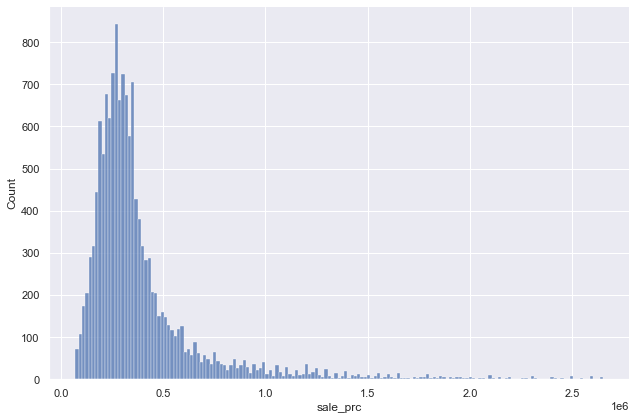

In [39]:
# Baseline distribution of all Sale Prices
sns.displot(y, height=6, aspect=1.5)

In [40]:
y.describe()

count    1.393200e+04
mean     3.999419e+05
std      3.172147e+05
min      7.200000e+04
25%      2.350000e+05
50%      3.100000e+05
75%      4.280000e+05
max      2.650000e+06
Name: sale_prc, dtype: float64

#### - The middle 50% of single family homes are selling in the $235k - $428k range, with a median of $310k
---

# III. Build Model

In [41]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

### Linear Models

In [42]:
from sklearn.linear_model import Ridge, LinearRegression

#### Linear Regression Model

In [43]:
# Model fitting (default)
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions from validation data
lr_preds = lr.predict(X_val)

# Coefficient table 
lr_coef_table = pd.DataFrame(data = lr.coef_, 
                             index= X_train.columns, 
                             columns= ['coefs']).sort_values(by='coefs', ascending=False)

### Visualizations
- Here, with results from the linear regression model plotted against the true values of the validation data, we can see that the linear regression is picking up on a trend, but is very narrow in its scope, and not a very accurate reflection of the true sale prices. 
- From this visual, we can assume this model accounts for about 60% of the data, and is not even capable of producing values in the outer 40%. With the model only accoutning for 60% of the data (we can quantify this exactly later), it is only capable of 60% accuracy at best. 
- The coefficients of the regression line give us an idea of the most influential variable on our target, sale price, but due to this model's poor performance the coefficients here have a similar 60% accuracy
- The R^2 score of 0.69, which we will later see indicates the linear model accounts for only 69% of the varience in the training dataset, and unable to account for the remaining 31% (we guessed 40% earlier, based on the scatter plot)


,coefs
longitude,2.209173e+06
structure_quality,7.411523e+04
tot_lvg_area,1.957985e+02
rail_dist,4.948766e+00
hwy_dist,4.198201e+00
lnd_sqfoot,3.129277e+00
ocean_dist,3.105934e+00
spec_feat_val,2.925836e+00
water_dist,3.886558e-01
cntr_dist,-1.872832e+00


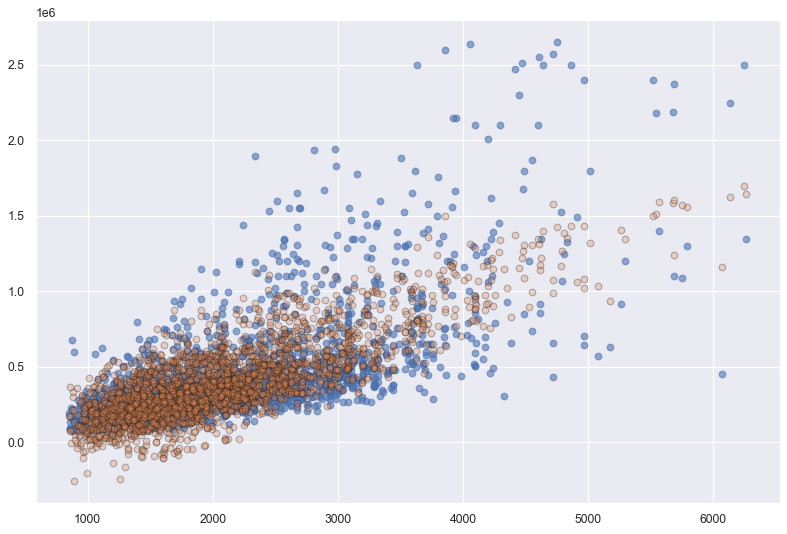

In [44]:
''' VISUALIZATIONS '''
display(lr_coef_table)

# Plotting results
from matplotlib.pyplot import figure
figure(figsize=(12, 8), dpi=80)

plt.scatter(X_val['tot_lvg_area'], y_val, alpha=.6)
plt.scatter(X_val['tot_lvg_area'], lr_preds, alpha=.3, edgecolors='k')

results_df = X_val.copy()
results_df['y_val'], results_df['lr_preds'] = y_val, lr_preds


# not needed atm:
# plt.scatter(y_val, lr_preds, edgecolors='k', alpha=.7)
# plt.scatter(y_train, lr.predict(X_train), edgecolors='k', alpha=.5)
# plt.show()
# sns.lmplot('tot_lvg_area', 'y_val', data = results_df)
# sns.lmplot('tot_lvg_area', 'lr_preds', data = results_df)

#### Ridge Regression Model

In [45]:
# Fit RidgeRegression Model
rr = Ridge(alpha= 1.0)
rr.fit(X_train, y_train)

Ridge()

In [46]:
rr_mae_t = mean_absolute_error(y_train, rr.predict(X_train))
rr_mae_v = mean_absolute_error(y_val, rr.predict(X_val))

### Tree-Based Models

In [47]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [48]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [49]:
from xgboost import XGBRegressor
# xgb = XGBRegressor(random_state= 42, n_estimators= 75, n_jobs= -1)
xgb = XGBRegressor(random_state= 42, n_jobs= -1)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### a. Tune Model

In [50]:
# import numpy as np
# regressor = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
#              gamma=0, gpu_id=-1, importance_type=None,
#              interaction_constraints='', learning_rate=0.300000012,
#              max_delta_step=0, max_depth=6, min_child_weight=1,
#              monotone_constraints='()', n_estimators=100, n_jobs=-1,
#              num_parallel_tree=1, predictor='auto', random_state=42,
#              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
#              tree_method='exact', validate_parameters=1, verbosity=None)

# params = {
#     'n_estimators': [100, 400, 800],
#     'max_depth': [3, 6, 9],
#     'learning_rate': [0.05, 0.1, 0.20],
#     'min_child_weight': [1, 10, 100]
#     }

In [51]:
# # ---- RANDOMIZED SEARCH CV() TEMPLATE ----
# from sklearn.model_selection import RandomizedSearchCV

# model_xgbrs = RandomizedSearchCV(
#     regressor,
#     random_state=42,
#     param_distributions = params,
#     n_jobs=-1,
#     cv=5, 
#     verbose=3,
#     n_iter = 10 
# )

# model_xgbrs.fit(X ,y)

# best_score = model_xgbrs.best_score_
# best_params = model_xgbrs.best_params_

# print('Best score for `model`:', best_score)
# print()
# print('Best params for `model`:', best_params)

# IV. Check Metrics
### 

In [52]:
def check_metrics(model):
  # print(model)
  print('Training MAE:', mean_absolute_error(y_train, model.predict(X_train)))
  print('Validation MAE:', mean_absolute_error(y_val, model.predict(X_val)))
  print('Validation R^2:', model.score(X_val, y_val))
  print()

# Model Selection: 
models = [lr, rr, dt, rf, xgb]

for m in models:
  print(m, '*default hyper/parameters')
  check_metrics(m)

LinearRegression() *default hyper/parameters
Training MAE: 112221.9684944449
Validation MAE: 116333.29341003476
Validation R^2: 0.6892745474934261

Ridge() *default hyper/parameters
Training MAE: 111425.22019898836
Validation MAE: 115965.95625352782
Validation R^2: 0.6908268946200824

DecisionTreeRegressor(random_state=42) *default hyper/parameters
Training MAE: 13.155481118156079
Validation MAE: 67359.80904522612
Validation R^2: 0.8061619323289735

RandomForestRegressor(random_state=42) *default hyper/parameters
Training MAE: 17751.799724277793
Validation MAE: 46444.579117611866
Validation R^2: 0.9197969207171917

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constrai

### a. Permutation Importance Metrics

In [53]:
from sklearn.inspection import permutation_importance
# Model Selection: 
model = xgb 

pimp = permutation_importance(model, X_val, y_val, random_state= 42)

In [54]:
pimp_data = {'imp_mean' : pimp['importances_mean'],
             'imp_std' : pimp['importances_std']}

permutation_importance_df = pd.DataFrame(pimp_data, index= X_val.columns).sort_values(by= 'imp_mean', ascending=False)
permutation_importance_df

,imp_mean,imp_std
tot_lvg_area,0.340880,0.009658
ocean_dist,0.221166,0.007850
cntr_dist,0.141936,0.008098
age,0.066235,0.008802
longitude,0.065662,0.008267
subcntr_di,0.055424,0.001240
structure_quality,0.054118,0.002693
lnd_sqfoot,0.049024,0.005331
latitude,0.029219,0.001494
water_dist,0.022682,0.002221


### b. Partial Dependence Plots for model (choice of one or two variables in each plot)

In [55]:
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import shap

ModuleNotFoundError: No module named 'pdpbox'

In [ ]:
feature = 'ocean_dist'

In [ ]:
isolate = pdp_isolate(
    model,
    dataset= X_val,
    model_features= X_val.columns,
    feature= feature
)

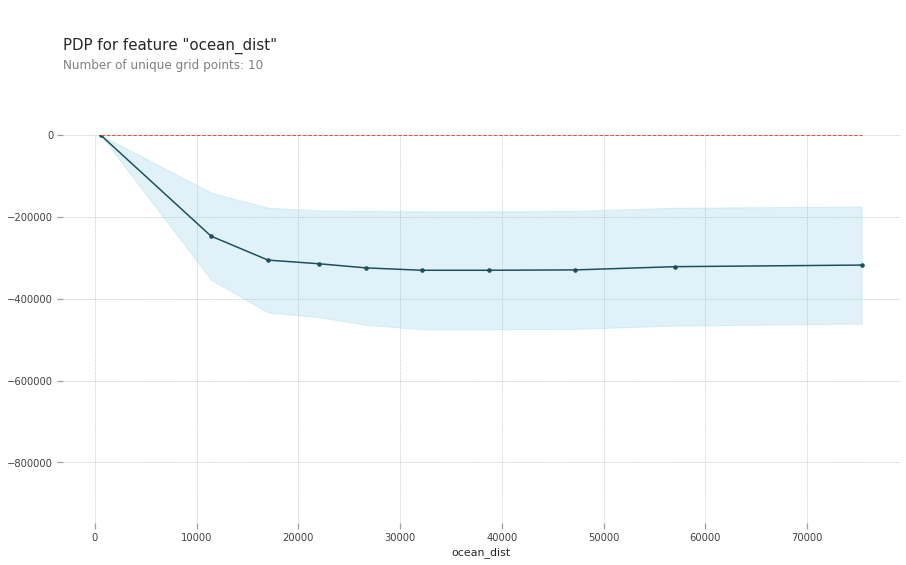

In [ ]:
pdp_plot(isolate, feature_name=feature);

In [ ]:
isolate.pdp

array([393099.75, 393423.9 , 393423.9 , 393423.9 , 393423.9 , 393423.9 ,
       390924.  , 358350.94, 358350.94, 764949.3 ], dtype=float32)

In [ ]:
features = ['tot_lvg_area', 'ocean_dist']

In [ ]:
interact = pdp_interact(
    model,
    dataset= X_val,
    model_features= X_val.columns,
    features= features
)

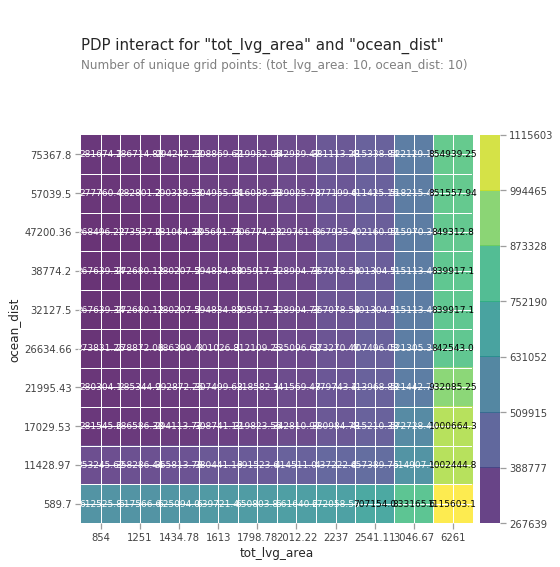

In [ ]:
pdp_interact_plot(interact, plot_type='grid', feature_names= features);

### c. Shapley force plot for an individual prediction

In [ ]:
sample_row = X_val[3:4]

In [ ]:
explainer = shap.TreeExplainer(model)

In [ ]:
shap_values = explainer.shap_values(sample_row)

In [ ]:
shap.initjs()
shap.force_plot(
    base_value = explainer.expected_value,
    shap_values = shap_values,
    features= sample_row
)

### d. Create Visualization

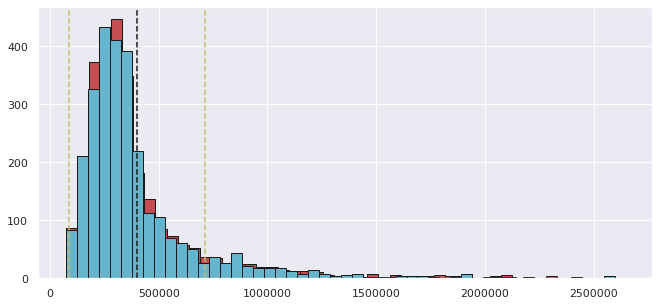

In [ ]:
import statistics

#  A look at predictions vs y_test and standard deviations for y_test
plt.hist(y_test, bins=50, color='r', edgecolor='k')
plt.hist(dt.predict(X_test), bins=50, color='c', edgecolor='k');

test_mean = statistics.mean(y_test)
pred_mean = statistics.mean(dt.predict(X_test))
test_std = statistics.stdev(y_test)
pred_std = statistics.stdev(dt.predict(X_test))

plt.axvline(test_mean, color='k', linestyle='dashed')
plt.axvline(test_mean + test_std, color='y', linestyle='dashed')
plt.axvline(test_mean - test_std, color='y', linestyle='dashed')

In [ ]:
import plotly.express as px

ModuleNotFoundError: No module named 'plotly'

In [ ]:
px.box(y, orientation='h')

In [ ]:
px.density_heatmap(df.latitude, df.longitude)